<a href="https://colab.research.google.com/github/huongpenguins/CNPM/blob/main/2_efficientdet_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
rebantadeyiiest_auairroboflowv2_path = kagglehub.dataset_download('rebantadeyiiest/auairroboflowv2')

print('Data source import complete.')

100%|██████████| 186M/186M [00:05<00:00, 33.7MB/s]

Extracting files...


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install albumentations==1.0.0
!pip install effdet==0.2.4
!pip install ensemble-boxes==1.0.6
!pip install fastcore==1.8.0
!pip install pytorch-lightning==2.5.3
!pip install timm==0.4.9


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.8.8
    Uninstalling fastcore-1.8.8:
      Successfully uninstalled fastcore-1.8.8
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.2/828.2 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.1/346.1 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.19
    Uninstalling timm-1.0.19:
      Successfully uninstalled timm-1.0.19


In [5]:
!git clone https://github.com/rwightman/efficientdet-pytorch.git

Cloning into 'efficientdet-pytorch'...
remote: Enumerating objects: 1050, done.
remote: Counting objects: 100% (1050/1050), done.
remote: Compressing objects: 100% (371/371), done.
remote: Total 1050 (delta 684), reused 935 (delta 653), pack-reused 0 (from 0)
Receiving objects: 100% (1050/1050), 376.42 KiB | 8.01 MiB/s, done.
Resolving deltas: 100% (684/684), done.


In [6]:
from pathlib import Path

# Đường dẫn đúng tới thư mục dữ liệu
dataset_path_images = Path('/content/drive/MyDrive/efficientdet/archive/images')
dataset_label = Path('/content/drive/MyDrive/efficientdet/archive/labels')
# Xem nội dung thư mục
print("Danh sách file/folder trong dataset:")
# print(list(dataset_path_images.iterdir()))
# print(list(dataset_label.iterdir()))


Danh sách file/folder trong dataset:


(640, 640)


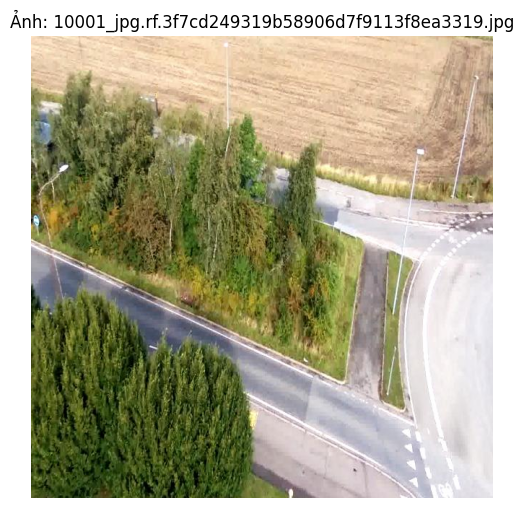

In [7]:
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

# Lấy danh sách các file ảnh .jpg
image_files = sorted(dataset_path_images.glob("*.jpg"))

# Kiểm tra có ảnh không
if len(image_files) == 0:
    print("Không tìm thấy ảnh nào trong thư mục.")
else:
    # Đọc ảnh đầu tiên
    img_path = image_files[0]
    img = Image.open(img_path)

    # Hiển thị ảnh
    print(img.size)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Ảnh: {img_path.name}")
    plt.show()


Dataset Adaptor


In [8]:
import os
import pandas as pd

data = []
# list_label = ["Bike","Bus","Car","Human","Motorcycle","Truck","Van"]
for filename in os.listdir(dataset_label):
    if filename.endswith('.txt'):
        filepath = os.path.join(dataset_label, filename)
        with open(filepath, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x_center,y_center,width,height = map(float, parts)
                    xmin = (x_center - width/2)*640
                    ymin = (y_center - height/2)*640
                    xmax = (x_center + width/2)*640
                    ymax = (y_center + height/2)*640
                    data.append({
                        'image': filename.replace('.txt', '.jpg'),
                        'class_id': int(class_id),
                        'xmin': xmin,
                        'ymin': ymin,
                        'xmax': xmax,
                        'ymax': ymax
                      })

df = pd.DataFrame(data)
print(df.head())


                                               image  class_id    xmin  \
0  13148_jpg.rf.70ede236fd4180a79db50c317ad1155d.jpg         2  607.25   
1  13148_jpg.rf.70ede236fd4180a79db50c317ad1155d.jpg         5  396.75   
2  13148_jpg.rf.70ede236fd4180a79db50c317ad1155d.jpg         2  471.75   
3  13148_jpg.rf.70ede236fd4180a79db50c317ad1155d.jpg         2  484.00   
4  13148_jpg.rf.70ede236fd4180a79db50c317ad1155d.jpg         6  490.75   

     ymin    xmax    ymax  
0  153.00  639.75  186.00  
1  107.75  444.25  171.25  
2   94.00  482.25  115.00  
3   97.00  497.00  115.00  
4   64.25  503.25   87.75  


In [9]:
df.head()

,image,class_id,xmin,ymin,xmax,ymax
0,13148_jpg.rf.70ede236fd4180a79db50c317ad1155d.jpg,2,607.25,153.00,639.75,186.00
1,13148_jpg.rf.70ede236fd4180a79db50c317ad1155d.jpg,5,396.75,107.75,444.25,171.25
2,13148_jpg.rf.70ede236fd4180a79db50c317ad1155d.jpg,2,471.75,94.00,482.25,115.00
3,13148_jpg.rf.70ede236fd4180a79db50c317ad1155d.jpg,2,484.00,97.00,497.00,115.00
4,13148_jpg.rf.70ede236fd4180a79db50c317ad1155d.jpg,6,490.75,64.25,503.25,87.75


In [10]:
print(df.columns)

Index(['image', 'class_id', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')


In [11]:
import matplotlib.pyplot as plt
from matplotlib import patches

def get_rectangle_edges_from_pascal_bbox(bbox, image_width=None, image_height=None):
    xmin,ymin,xmax,ymax = bbox
    bottom_left = (xmin, ymin)
    width_input = xmax - xmin
    height_input = ymax - ymin

    # print(f"  Normalized: xmin:{xmin:.4f}, ymin:{ymin:.4f}, xmax:{xmax:.4f}, ymax:{ymax:.4f}")
    print(f"  Pixel: xmin:{xmin:.1f}, ymin:{ymin:.1f}, xmax:{xmax:.1f}, ymax:{ymax:.1f}")
    print(f"  x_bottom_left: {bottom_left[0]:.1f}, y_bottom_left: {bottom_left[1]:.1f}")
    print("")

    return bottom_left, width_input, height_input

def draw_pascal_bboxes(
    plot_ax,
    bboxes,
    class_id,
    image_width=640,
    image_height=640,
    get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    print(f"Drawing {len(bboxes)} bounding boxes on image ({image_width}x{image_height})")
    print("="*50)
    list_label = ["Bike","Bus","Car","Human","Motorcycle","Truck","Van"]
    for i, bbox in enumerate(bboxes):
        print(f"BBox {i+1}:")
        bottom_left, width, height = get_rectangle_corners_fn(bbox, image_width, image_height)

        rect_1 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=4,
            edgecolor="black",
            fill=False,
        )
        rect_2 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=2,
            edgecolor="white",  # Changed to red to make it more visible
            fill=False,
        )

        # Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        plot_ax.add_patch(rect_2)

        # Add bbox number text on the image - positioned at top-left corner of bbox
        text_x = bottom_left[0] + 2
        text_y = bottom_left[1] + 20  # Slightly below the top edge

        plot_ax.text(
            text_x, text_y,
            list_label[class_id[i]],
            color='white',
            fontsize=14,
            weight='bold',
            bbox=dict(boxstyle="round,pad=0.4", facecolor='red', alpha=0.8),
            verticalalignment='top'
        )

def show_image_1(
    image,class_labels, bboxes=None, draw_bboxes_fn=draw_pascal_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    if bboxes is not None:
        # Get image dimensions for coordinate scaling
        image_width, image_height = image.size
        draw_bboxes_fn(ax, bboxes,class_labels, image_width, image_height)

    plt.show()

Dataset Adaptor


In [12]:
from pathlib import Path

import PIL

import numpy as np

class DatasetAdaptor:
    def __init__(self, images_dir_path, annotations_dataframe):
        self.images_dir_path = Path(images_dir_path)
        self.annotations_df = annotations_dataframe
        self.images = self.annotations_df.image.unique().tolist()

    def __len__(self) -> int:
        return len(self.images)

    def get_image_and_labels_by_idx(self, index):
        image_name = self.images[index]
        image = PIL.Image.open(self.images_dir_path / image_name)
        image_annotations = self.annotations_df[self.annotations_df.image == image_name]

        pascal_bboxes = image_annotations[["xmin","ymin","xmax","ymax"]].values

        # Get class labels
        if 'class_id' in self.annotations_df.columns:
            class_labels = image_annotations['class_id'].values
        elif 'class' in self.annotations_df.columns:
            class_labels = image_annotations['class'].values
        else:
            class_labels = np.zeros(len(pascal_bboxes))

        return image, pascal_bboxes, class_labels, index

    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        print(f"image_id: {image_id}")
        show_image_1(image,class_labels, bboxes.tolist())
        print(class_labels)

In [13]:
data_train = DatasetAdaptor(dataset_path_images,df)


image_id: 1
Drawing 3 bounding boxes on image (640x640)
BBox 1:
  Pixel: xmin:162.1, ymin:207.9, xmax:303.9, ymax:324.1
  x_bottom_left: 162.1, y_bottom_left: 207.9

BBox 2:
  Pixel: xmin:166.2, ymin:59.9, xmax:299.8, ymax:173.1
  x_bottom_left: 166.2, y_bottom_left: 59.9

BBox 3:
  Pixel: xmin:26.1, ymin:561.0, xmax:74.9, ymax:640.0
  x_bottom_left: 26.1, y_bottom_left: 561.0



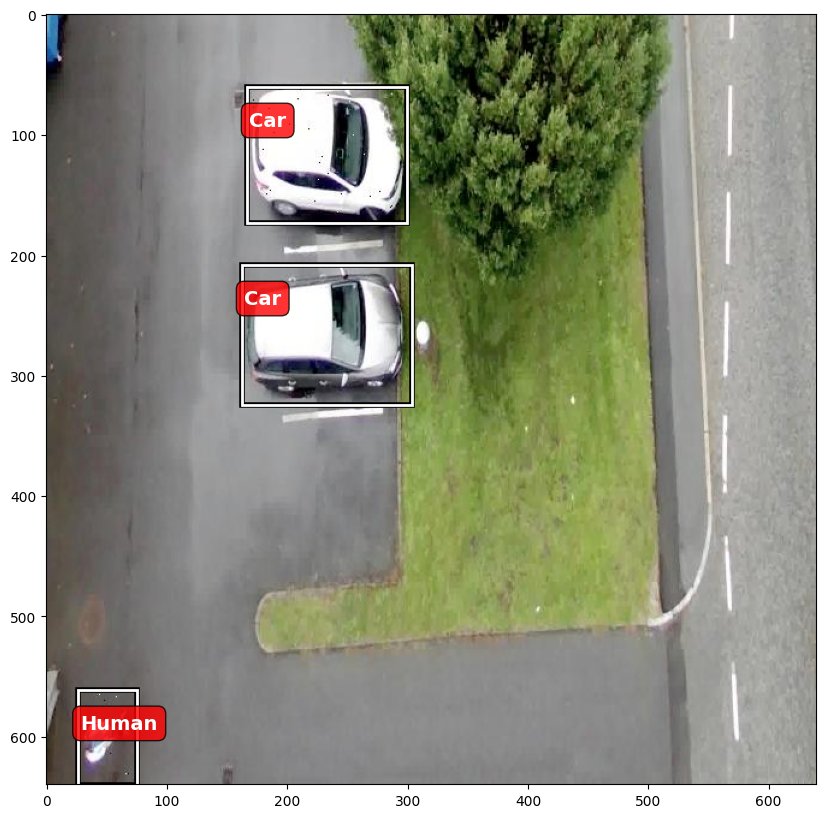

[2 2 3]


In [14]:
data_train.show_image(1)

Creating the model


In [17]:
from effdet.config.model_config import efficientdet_model_param_dict
from effdet import get_efficientdet_config,EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet.config.model_config import efficientdet_model_param_dict


In [18]:
print(f"number of config: {len(efficientdet_model_param_dict)} ")
list(efficientdet_model_param_dict.keys())[::3]

number of config: 44 


['efficientdet_d0',
 'efficientdet_d3',
 'resdet50',
 'cspresdext50pan',
 'mixdet_m',
 'mobiledetv2_120d',
 'efficientdet_q1',
 'efficientdet_es',
 'tf_efficientdet_d0',
 'tf_efficientdet_d3',
 'tf_efficientdet_d6',
 'tf_efficientdet_d0_ap',
 'tf_efficientdet_d3_ap',
 'tf_efficientdet_lite0',
 'tf_efficientdet_lite3']

In [19]:
import timm
timm.list_models('tf_efficientnetv2_*')

['tf_efficientnetv2_b0',
 'tf_efficientnetv2_b1',
 'tf_efficientnetv2_b2',
 'tf_efficientnetv2_b3',
 'tf_efficientnetv2_l',
 'tf_efficientnetv2_l_in21ft1k',
 'tf_efficientnetv2_l_in21k',
 'tf_efficientnetv2_m',
 'tf_efficientnetv2_m_in21ft1k',
 'tf_efficientnetv2_m_in21k',
 'tf_efficientnetv2_s',
 'tf_efficientnetv2_s_in21ft1k',
 'tf_efficientnetv2_s_in21k']

In [20]:
def create_model(num_classes = 7,image_size = 512,architecture = "tf_efficientnetv2_l"):
    efficientdet_model_param_dict['tf_efficientnetv2_l'] =dict(
        name = 'tf_efficientnetv2_l',
        backbone_name= 'tf_efficientnetv2_l',
        backbone_args = dict(drop_path_rate = 0.2),
        num_classes = num_classes, url =''
    )

    config = get_efficientdet_config(architecture)
    config.update({'num_classes' : num_classes})
    config.update({'image_size' : (image_size,image_size)})
    # print(f"Create_model DEBUG")
    # print(f"Input image_size:{image_size}")
    # print(f"Config image_size: {config.get('image_size',"NOT FOUND")}")
    print(config)

    net = EfficientDet(config, pretrained_backbone = False)
    net.class_net = HeadNet(
        config,
        num_outputs = config.num_classes,
    )
    return DetBenchTrain(net,config)

Define the EfficientDet Dataset

In [21]:
from torch.utils.data import Dataset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


def get_train_transforms(target_img_size=512):
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            # A.ShiftScaleRotate(p=0.5,rotate_limit=15,scale_limit = 0.1,border_mode= 0),
            A.RandomBrightnessContrast(p = 0.5),
            # A.HueSaturationValue(p = 0.5),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )

class EfficientDetDataset(Dataset):
    def __init__(
        self, dataset_adaptor, transforms=get_valid_transforms()
    ):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        (
            image,
            pascal_bboxes,
            class_labels,
            image_id,
        ) = self.ds.get_image_and_labels_by_idx(index)

        sample = {
            "image": np.array(image, dtype=np.float32),
            "bboxes": pascal_bboxes,
            "labels": class_labels,
        }

        # print(f"=== DATASET DEBUG - Sample {index} ===")
        # print(f"Original image size: {image.size}")  # (W, H)
        sample = self.transforms(**sample)

        sample["bboxes"] = np.array(sample["bboxes"])
        image = sample["image"]
        pascal_bboxes = sample["bboxes"]
        labels = sample["labels"]

        _, new_h, new_w = image.shape
        # print(f"After transforms: {new_w}x{new_h}")  # Should be 512x512
        # print(f"Bboxes after transforms: {sample['bboxes'][:3]}")  # First 3 boxes

        # # Check coordinate ranges
        # if len(sample["bboxes"]) > 0:
        #     coords = sample["bboxes"]
        #     print(f"Coord ranges: min={coords.min():.1f}, max={coords.max():.1f}")
        #     print(f"Within [0,512]: {(coords >= 0).all() and (coords <= 512).all()}")

        # Add a check for empty bboxes before converting
        if len(sample["bboxes"]) > 0:
            sample["bboxes"][:, [0, 1, 2, 3]] = sample["bboxes"][:, [1, 0, 3, 2]]  # convert to yxyx
        else:
            # Handle the case with no bounding boxes, e.g., create dummy bboxes and labels
            sample["bboxes"] = np.zeros((0, 4), dtype=np.float32)
            labels = np.zeros((0,), dtype=np.int64)


        target = {
            "bboxes": torch.as_tensor(sample["bboxes"], dtype=torch.float32),
            "labels": torch.as_tensor(labels),
            "image_id": torch.tensor([image_id]),
            "img_size": (new_h, new_w),
            "img_scale": torch.tensor([1.0]),
        }

        return image, target, image_id

    def __len__(self):
        return len(self.ds)

Define the DataModule

In [22]:
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader

class EfficientDetDataModule(LightningDataModule):

    def __init__(self,
                train_dataset_adaptor,
                validation_dataset_adaptor,
                train_transforms=get_train_transforms(target_img_size=512),
                valid_transforms=get_valid_transforms(target_img_size=512),
                num_workers=4,
                batch_size=8):

        self.train_ds = train_dataset_adaptor
        self.valid_ds = validation_dataset_adaptor
        self.train_tfms = train_transforms
        self.valid_tfms = valid_transforms
        self.num_workers = num_workers
        self.batch_size = batch_size
        super().__init__()

    def train_dataset(self) -> EfficientDetDataset:
        return EfficientDetDataset(
            dataset_adaptor=self.train_ds,
            transforms=self.train_tfms
        )

    def train_dataloader(self) -> DataLoader:
        train_dataset = self.train_dataset()
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

        return train_loader

    def val_dataset(self) -> EfficientDetDataset:
        return EfficientDetDataset(
            dataset_adaptor=self.valid_ds, transforms=self.valid_tfms
        )

    def val_dataloader(self) -> DataLoader:
        valid_dataset = self.val_dataset()
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

        return valid_loader

    @staticmethod
    def collate_fn(batch):
        images, targets, image_ids = tuple(zip(*batch))
        images = torch.stack(images)
        images = images.float()

        boxes = [target["bboxes"].float() for target in targets]
        labels = [target["labels"].float() for target in targets]
        img_size = torch.tensor([target["img_size"] for target in targets]).float()
        img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

        annotations = {
            "bbox": boxes,
            "cls": labels,
            "img_size": img_size,
            "img_scale": img_scale,
        }

        return images, annotations, targets, image_ids

In [ ]:
# !pip install ensemble-boxes


Define the training loop

In [23]:
from numbers import Number
from typing import List
from functools import singledispatch

import numpy as np
import torch

# from fastcore.dispatch import dispatch
from pytorch_lightning import LightningModule
# from pytorch_lightning.core.decorators import auto_move_data


from ensemble_boxes import ensemble_boxes_wbf


def run_wbf(predictions, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    bboxes = []
    confidences = []
    class_labels = []

    for prediction in predictions:
        boxes = [(prediction["boxes"] / image_size).tolist()]
        scores = [prediction["scores"].tolist()]
        labels = [prediction["classes"].tolist()]

        boxes, scores, labels = ensemble_boxes_wbf.weighted_boxes_fusion(
            boxes,
            scores,
            labels,
            weights=weights,
            iou_thr=iou_thr,
            skip_box_thr=skip_box_thr,
        )
        boxes = boxes * (image_size - 1)
        bboxes.append(boxes.tolist())
        confidences.append(scores.tolist())
        class_labels.append(labels.tolist())

    return bboxes, confidences, class_labels


class EfficientDetModel(LightningModule):
    def __init__(
        self,
        num_classes=7,
        img_size=512,
        prediction_confidence_threshold=0.2,
        learning_rate=0.0002,
        wbf_iou_threshold=0.44,
        inference_transforms=get_valid_transforms(target_img_size=512),
        model_architecture='tf_efficientnetv2_l',
    ):
        # print(f"==EfficientDetModel DEBUG ==")
        # print(f"img_size parameter: {img_size}")
        # print(f"expected: 512")
        super().__init__()

        self.img_size = img_size
        # print(f"Calling create_model with:")
        # print(f"  num_classes: {num_classes}")
        # print(f"  img_size: {img_size}")
        # print(f"  architecture: {model_architecture}")
        self.model = create_model(
            num_classes, img_size, architecture=model_architecture
        )
        self.prediction_confidence_threshold = prediction_confidence_threshold
        self.lr = learning_rate
        self.wbf_iou_threshold = wbf_iou_threshold
        self.inference_tfms = inference_transforms


    # @auto_move_data
    def forward(self, images, targets):
        return self.model(images, targets)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr)


    def training_step(self, batch, batch_idx):
        images, annotations, _, image_ids = batch

        losses = self.model(images, annotations)

        logging_losses = {
            "class_loss": losses["class_loss"].detach(),
            "box_loss": losses["box_loss"].detach(),
        }

        self.log("train_loss", losses["loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True)
        self.log(
            "train_class_loss", losses["class_loss"], on_step=True, on_epoch=True, prog_bar=True,
            logger=True
        )
        self.log("train_box_loss", losses["box_loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True)

        return losses['loss']


    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        images, annotations, targets, image_ids = batch
        outputs = self.model(images, annotations)

        detections = outputs["detections"]

        batch_predictions = {
            "predictions": detections,
            "targets": targets,
            "image_ids": image_ids,
        }

        logging_losses = {
            "class_loss": outputs["class_loss"].detach(),
            "box_loss": outputs["box_loss"].detach(),
        }

        self.log("valid_loss", outputs["loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, sync_dist=True)
        self.log(
            "valid_class_loss", logging_losses["class_loss"], on_step=True, on_epoch=True,
            prog_bar=True, logger=True, sync_dist=True
        )
        self.log("valid_box_loss", logging_losses["box_loss"], on_step=True, on_epoch=True,
                 prog_bar=True, logger=True, sync_dist=True)

        return {'loss': outputs["loss"], 'batch_predictions': batch_predictions}


    # @singledispatch
    def predict(self, images: List):
        """
        For making predictions from images
        Args:
            images: a list of PIL images

        Returns: a tuple of lists containing bboxes, predicted_class_labels, predicted_class_confidences

        """
        image_sizes = [(image.size[1], image.size[0]) for image in images]
        images_tensor = torch.stack(
            [
                self.inference_tfms(
                    image=np.array(image, dtype=np.float32),
                    labels=np.ones(1),
                    bboxes=np.array([[0, 0, 1, 1]]),
                )["image"]
                for image in images
            ]
        )

        return self._run_inference(images_tensor, image_sizes)

    # @predict.register(torch.Tensor) # Register phiên bản thứ hai cho input torch.Tensor
    # def predict(self, images_tensor: torch.Tensor):
    #     """
    #     For making predictions from tensors returned from the model's dataloader
    #     Args:
    #         images_tensor: the images tensor returned from the dataloader

    #     Returns: a tuple of lists containing bboxes, predicted_class_labels, predicted_class_confidences

    #     """
    #     if images_tensor.ndim == 3:
    #         images_tensor = images_tensor.unsqueeze(0)
    #     if (
    #         images_tensor.shape[-1] != self.img_size
    #         or images_tensor.shape[-2] != self.img_size
    #     ):
    #         raise ValueError(
    #             f"Input tensors must be of shape (N, 3, {self.img_size}, {self.img_size})"
    #         )

    #     num_images = images_tensor.shape[0]
    #     image_sizes = [(self.img_size, self.img_size)] * num_images

    #     return self._run_inference(images_tensor, image_sizes)

    def _run_inference(self, images_tensor, image_sizes):
        dummy_targets = self._create_dummy_inference_targets(
            num_images=images_tensor.shape[0]
        )

        detections = self.model(images_tensor.to(self.device), dummy_targets)[
            "detections"
        ]
        (
            predicted_bboxes,
            predicted_class_confidences,
            predicted_class_labels,
        ) = self.post_process_detections(detections)

        scaled_bboxes = self.__rescale_bboxes(
            predicted_bboxes=predicted_bboxes, image_sizes=image_sizes
        )

        return scaled_bboxes, predicted_class_labels, predicted_class_confidences

    def _create_dummy_inference_targets(self, num_images):
        dummy_targets = {
            "bbox": [
                torch.tensor([[0.0, 0.0, 0.0, 0.0]], device=self.device)
                for i in range(num_images)
            ],
            "cls": [torch.tensor([1.0], device=self.device) for i in range(num_images)],
            "img_size": torch.tensor(
                [(self.img_size, self.img_size)] * num_images, device=self.device
            ).float(),
            "img_scale": torch.ones(num_images, device=self.device).float(),
        }

        return dummy_targets

    def post_process_detections(self, detections):
        predictions = []
        for i in range(detections.shape[0]):
            predictions.append(
                self._postprocess_single_prediction_detections(detections[i])
            )

        predicted_bboxes, predicted_class_confidences, predicted_class_labels = run_wbf(
            predictions, image_size=self.img_size, iou_thr=self.wbf_iou_threshold
        )

        return predicted_bboxes, predicted_class_confidences, predicted_class_labels

    def _postprocess_single_prediction_detections(self, detections):
        boxes = detections.detach().cpu().numpy()[:, :4]
        scores = detections.detach().cpu().numpy()[:, 4]
        classes = detections.detach().cpu().numpy()[:, 5]
        indexes = np.where(scores > self.prediction_confidence_threshold)[0]
        boxes = boxes[indexes]

        return {"boxes": boxes, "scores": scores[indexes], "classes": classes[indexes]}

    def __rescale_bboxes(self, predicted_bboxes, image_sizes):
        scaled_bboxes = []
        for bboxes, img_dims in zip(predicted_bboxes, image_sizes):
            im_h, im_w = img_dims

            if len(bboxes) > 0:
                scaled_bboxes.append(
                    (
                        np.array(bboxes)
                        * [
                            im_w / self.img_size,
                            im_h / self.img_size,
                            im_w / self.img_size,
                            im_h / self.img_size,
                        ]
                    ).tolist()
                )
            else:
                scaled_bboxes.append(bboxes)

        return scaled_bboxes

In [24]:
dm = EfficientDetDataModule(train_dataset_adaptor = data_train,
                            validation_dataset_adaptor = data_train,
                           num_workers = 4,batch_size = 2)

In [25]:
# # Thêm vào sau khi tạo model:
# def debug_anchor_creation(model):
#     print(f"=== ANCHOR DEBUG ===")

#     # Truy cập anchor labeler (có thể khác tùy implementation)
#     try:
#         # Thử các cách truy cập anchor khác nhau:
#         if hasattr(model, 'anchor_labeler'):
#             anchors = model.anchor_labeler.anchors
#         elif hasattr(model, 'model') and hasattr(model.model, 'anchor_labeler'):
#             anchors = model.model.anchor_labeler.anchors
#         elif hasattr(model, 'anchors'):
#             anchors = model.anchors
#         else:
#             print("Cannot find anchors in model!")
#             return

#         print(f"Anchors image_size: {anchors.image_size}")
#         print(f"Expected: (512, 512)")
#         print(f"Match: {anchors.image_size == (512, 512)}")
#         print(f"Total anchors: {len(anchors.boxes)}")

#         # Kiểm tra feat_sizes
#         print(f"Feature sizes:")
#         for level in range(anchors.min_level, anchors.max_level + 1):
#             feat_size = anchors.feat_sizes[level]
#             expected_h = 512 // (2 ** level)
#             expected_w = 512 // (2 ** level)
#             print(f"  Level {level}: actual={feat_size}, expected=({expected_h}, {expected_w})")

#     except Exception as e:
#         print(f"Error accessing anchors: {e}")

# # Sử dụng:
model = EfficientDetModel(num_classes=7, img_size=512)
# debug_anchor_creation(model)

{'name': 'tf_efficientnetv2_l', 'backbone_name': 'tf_efficientnetv2_l', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 7, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_after_downsample': False, 'conv_bn_relu_pattern': False, 'use_native_resize_op': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'ma

In [26]:
from pytorch_lightning import Trainer

In [27]:
trainer = Trainer(
        # gpus=[0],
        max_epochs=5, num_sanity_val_steps=1,
    )

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
import numpy as np
trainer.fit(model,dm)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | DetBenchTrain | 116 M  | train
------------------------------------------------
116 M     Trainable params
0         Non-trainable params
116 M     Total params
467.638   Total estimated model params size (MB)
1349      Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(),'trained_effdet')

In [ ]:
model = EfficientDetModel(
    num_classes = 7,
    img_size = 512
)
model.load_state_dict(torch.load('trained_effdet'))

In [ ]:
model.eval()

In [ ]:
from effdet import DetBenchPredict
# Wrap model cho inference (predict)
bench = DetBenchPredict(model.model)  # model.model là EfficientDet inner
bench.eval()  # Eval mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bench.to(device)
print("Model loaded from weights successfully!")

In [ ]:
image1, truth_bboxes1, class_name1, _ = data_train.get_image_and_labels_by_idx(0)
image2, truth_bboxes2, class_name2, _ = data_train.get_image_and_labels_by_idx(1)

In [ ]:
images = [image1, image2]

In [ ]:
predicted_bboxes, predicted_class_confidences, predicted_class_labels = model.predict(images)

In [ ]:
def compare_bboxes_for_image(
    image,
    predicted_bboxes,
    class_label,
    actual_bboxes,
    draw_bboxes_fn=draw_pascal_bboxes,
    figsize=(20, 20),
):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(image)
    ax1.set_title("Prediction")
    ax2.imshow(image)
    ax2.set_title("Actual")

    draw_bboxes_fn(ax1, predicted_bboxes,class_label)
    draw_bboxes_fn(ax2, actual_bboxes,class_label)

    plt.show()

In [ ]:
compare_bboxes_for_image(image1, predicted_bboxes=predicted_bboxes[0],class_label = predicted_class_labels[0], actual_bboxes=truth_bboxes1.tolist())